# Import Data

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import io
from contextlib import redirect_stdout, redirect_stderr


try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()
    
parent_dir = os.path.join(current_dir, '..')
sys.path.insert(0, parent_dir)
    
    
from analysis_scripts.cfg import CFG

In [33]:
data_oc_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_signal.csv')
data_mb_df = pd.read_csv('/home/ome123/Рабочий стол/SPD/SPD_Lc_pKpi_27/Data/analysed_background.csv')

In [34]:
data_oc_df = data_oc_df.drop(['n_event'], axis=1)

mass_mask = (data_oc_df['mass_Lc'] > CFG.mass_interval[0]) \
            & ( data_oc_df['mass_Lc'] < CFG.mass_interval[1]) \
            & (data_oc_df['true_decay'] == 1)
            
data_oc_df = data_oc_df[mass_mask]
data_oc_df['tag'] = 'Sig'

data_mb_df = data_mb_df.drop(['n_event'], axis=1)

mass_mask = (data_mb_df['mass_Lc'] > CFG.mass_interval[0]) & ( data_mb_df['mass_Lc'] < CFG.mass_interval[1])

data_mb_df = data_mb_df[mass_mask]
data_mb_df['tag'] = 'Bg'

raw_df = pd.concat([data_oc_df, data_mb_df], axis=0).reset_index(drop=True)

raw_df['cosAngle_r_Lc_momentum_Lc_xy'] = raw_df['cosAngle_r_Lc_momentum_Lc_xy'].apply(np.cos)
raw_df['cosAngle_r_Lc_sum_momentum_xy'] = raw_df['cosAngle_r_Lc_sum_momentum_xy'].apply(np.cos)
raw_df['cosAngle_momentum_Lc_sum_momentum_xy'] = raw_df['cosAngle_momentum_Lc_sum_momentum_xy'].apply(np.cos)

raw_df['cosAngle_r_Lc_momentum_Lc_xy_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc_xy'] < 0, 'cosAngle_r_Lc_momentum_Lc_xy']
raw_df['cosAngle_r_Lc_momentum_Lc_xy_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_momentum_Lc_xy'] > 0, 'cosAngle_r_Lc_momentum_Lc_xy']

raw_df['cosAngle_r_Lc_sum_momentum_xy_left'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum_xy'] < 0, 'cosAngle_r_Lc_sum_momentum_xy']
raw_df['cosAngle_r_Lc_sum_momentum_xy_right'] = raw_df.loc[raw_df['cosAngle_r_Lc_sum_momentum_xy'] > 0, 'cosAngle_r_Lc_sum_momentum_xy']

raw_df['l_over_dl_XY'] = raw_df['lengthXY_Lc'] / raw_df['dlengthXY_Lc']

* Perform selection in the mass range of 8.7 $\sigma$.
* Convert cosAngle to actual cos.
* Add left and right components to some variables to treat them separately.
* Add l over dl in xy plane.

# Preselection

1. Preselection performs simple quantile-based selection. It cuts off all events that lie outside the quantile_left and quantile_right quantiles based on the signal distribution. The selection process begins if there are any signal events outside the interval:
(mean - safety_interval × indent; mean + safety_interval × indent).

2. Select only cases where the number of tracks selected for PV reconstruction is greater than min_tracks_after_refit.

In [35]:
from analysis_scripts.selection_scripts import auto_preselection


proc_df = raw_df.copy()

min_tracks_after_re_fit = 7

proc_df = proc_df[proc_df['kf_pv_size_after_re_fit'] > min_tracks_after_re_fit]

features_to_select = [
    'P_p', 'P_pip', 'P_K', 'P_Lc', 'eta_p', 'eta_pip',
       'eta_K', 'eta_Lc', 'Pt_Lc', 'Pt_p', 'Pt_K', 'Pt_pip', 'lengthXY_Lc',
       'dlengthXY_Lc', 'ctau_Lc', 'OA_p', 'OA_K', 'OA_pip', 'ptOverE',
       'chi2_Lc_PV_xy', 'dist_Lc_PV_xy', 'dist_Lc_PV_xy_custom',
       'chi2_p_PV_xy', 'dist_p_PV_xy', 'dist_p_PV_xy_custom', 'chi2_K_PV_xy',
       'dist_K_PV_xy', 'dist_K_PV_xy_custom', 'chi2_pip_PV_xy',
       'dist_pip_PV_xy', 'dist_pip_PV_xy_custom', 'chi2_p_Lc_xy',
       'dist_p_Lc_xy', 'dist_p_Lc_xy_custom', 'chi2_K_Lc_xy', 'dist_K_Lc_xy',
       'dist_K_Lc_xy_custom', 'chi2_pip_Lc_xy', 'dist_pip_Lc_xy',
       'dist_pip_Lc_xy_custom', 'chi2_Lc', 'chi2_K_pip_xy', 'dist_K_pip_xy',
       'dist_K_pip_xy_custom', 'chi2_p_K_xy', 'dist_p_K_xy',
       'dist_p_K_xy_custom', 'chi2_p_pip_xy', 'dist_p_pip_xy',
       'dist_p_pip_xy_custom', 'cosAngle_momentum_Lc_sum_momentum_xy',
       'xF', 'multiplicity', 'cosAngle_r_Lc_momentum_Lc_xy_left',
       'cosAngle_r_Lc_momentum_Lc_xy_right',
       'cosAngle_r_Lc_sum_momentum_xy_left',
       'cosAngle_r_Lc_sum_momentum_xy_right', 'l_over_dl_XY'
]

# Carefully handle _left, _right features
selection_df, mask = auto_preselection(
    df=proc_df,
    features=features_to_select,
    safety_interval=0.9,
    indent=2,
    quantile_left=1e-2,
    quantile_right=1-1e-2,
    recursive=True
)

proc_df = proc_df.query(mask)

proc_df_copy = proc_df.copy()

sig_eff_presel = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc'].count() / raw_df.loc[raw_df['tag'] == 'Sig', 'mass_Lc'].count()
bg_eff_presel = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc'].count() / raw_df.loc[raw_df['tag'] == 'Bg', 'mass_Lc'].count()

print(f'Signal efficiency: {sig_eff_presel}')
print(f'Background Suppression: {bg_eff_presel}')

Signal efficiency: 0.5005117308198415
Background Suppression: 0.15165792950603077


# PV FIT

In [36]:
# Remove duplicated PVs

proc_PV_df = proc_df.drop_duplicates(subset=('id')).copy()
proc_PV_df = proc_PV_df[[
    'tag', 'PV_diff_ES_x', 'PV_diff_ES_y', 'PV_diff_ES_z'
]]
proc_PV_df = proc_PV_df.reset_index(drop=True)

proc_PV_df.head()

,tag,PV_diff_ES_x,PV_diff_ES_y,PV_diff_ES_z
0,Sig,0.002396,-0.003116,-0.001275
1,Sig,-0.002551,-0.000763,0.000753
2,Sig,0.001339,-0.002063,0.001079
3,Sig,-0.006873,0.004778,-0.005275
4,Sig,-0.008425,0.001475,0.003281


### PV x-projection

Method: Nelder-Mead
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
****************************************************************************************************
New best method: trust-constr, success: True
****************************************************************************************************
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_

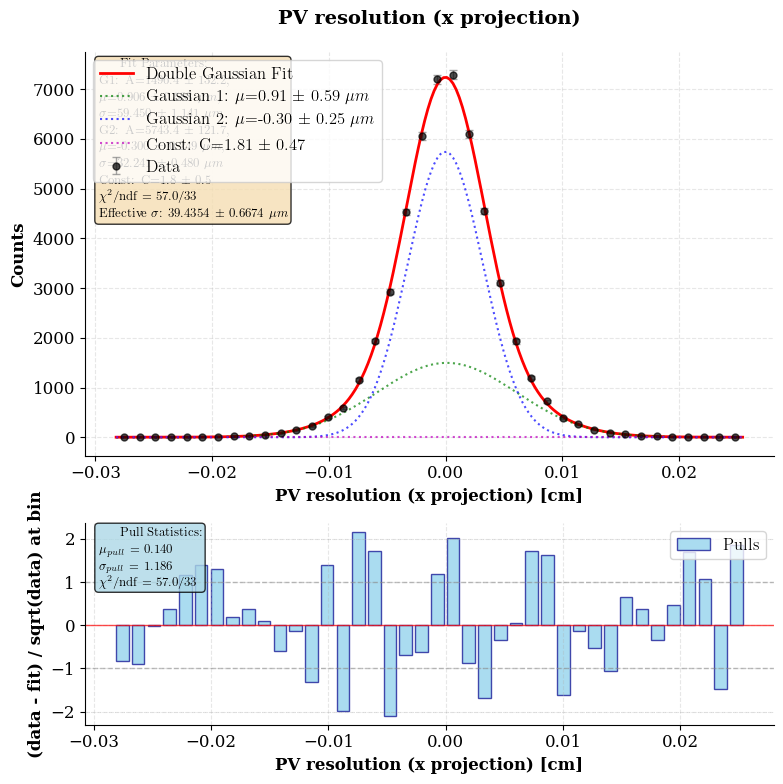

In [37]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'PV_diff_ES_x'
distr = proc_PV_df.loc[proc_PV_df['tag'] == 'Sig', distr_name]
distr_sel = distr[abs(distr) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1e4,
                unit_name='$\\mu m$'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='PV resolution (x projection)',
    x_label='PV resolution (x projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1e4,
    unit_name='$\\mu m$'
)

plt.savefig(f'../plots/{distr_name}.pdf')

### PV y-projection

Method: Nelder-Mead
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
****************************************************************************************************
New best method: trust-constr, success: True
****************************************************************************************************
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_

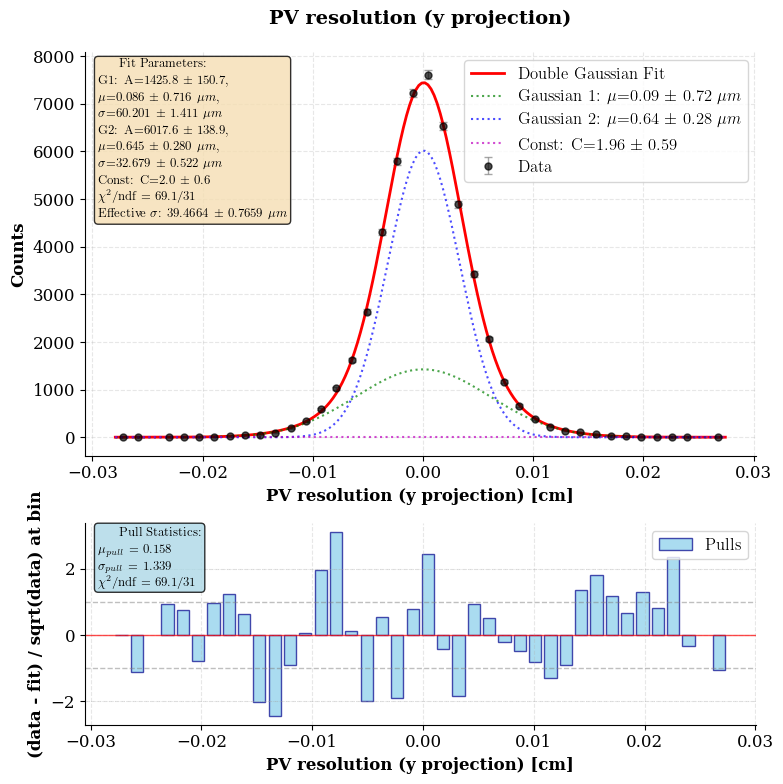

In [38]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'PV_diff_ES_y'
distr = proc_PV_df.loc[proc_PV_df['tag'] == 'Sig', distr_name]
distr_sel = distr[abs(distr) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1e4,
                unit_name='$\\mu m$'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='PV resolution (y projection)',
    x_label='PV resolution (y projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1e4,
    unit_name='$\\mu m$'
)

plt.savefig(f'../plots/{distr_name}.pdf')

### PV z-projection

Method: Nelder-Mead
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='Powell'
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 22
Final objective value: 58.941480
Chi-squared: 58.94
Reduced chi-squared: 1.786
---------------------------------------------

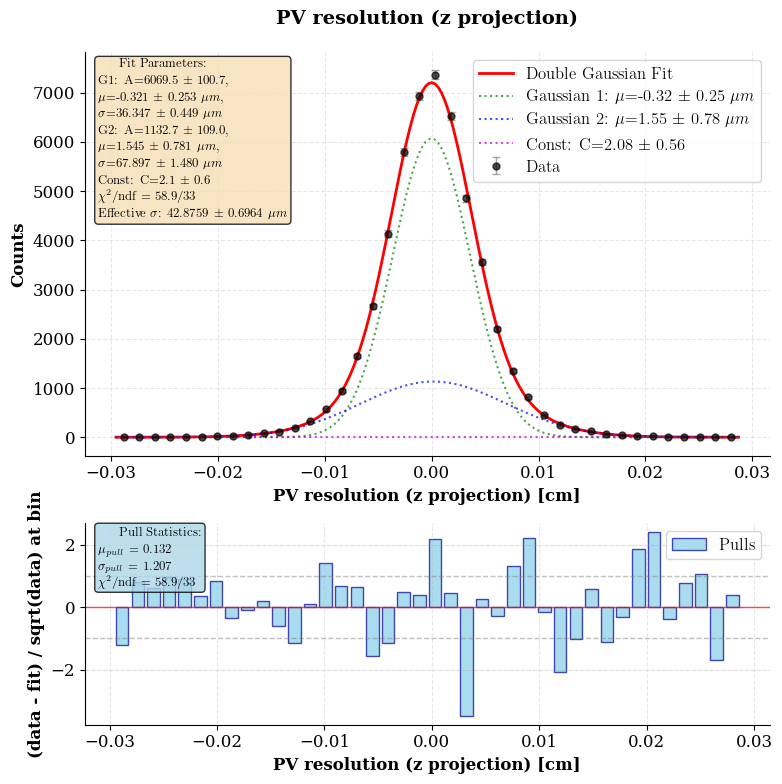

In [39]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'PV_diff_ES_z'
distr = proc_PV_df.loc[proc_PV_df['tag'] == 'Sig', distr_name]
distr_sel = distr[abs(distr) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1e4,
                unit_name='$\\mu m$'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='PV resolution (z projection)',
    x_label='PV resolution (z projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1e4,
    unit_name='$\\mu m$'
)

plt.savefig(f'../plots/{distr_name}.pdf')

# SV FIT

### SV x-projection

Method: Nelder-Mead
****************************************************************************************************
New best method: Nelder-Mead, success: True
****************************************************************************************************
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_m

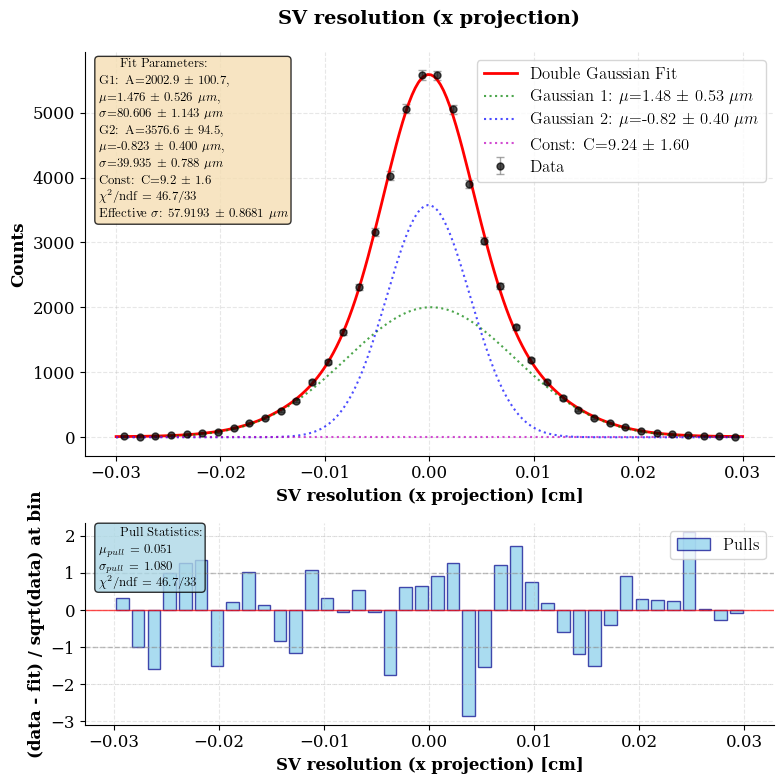

In [40]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'Lc_diff_x'

distr = proc_df.loc[proc_df['tag'] == 'Sig', distr_name]
distr_sel = distr[abs(distr) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1e4,
                unit_name='$\\mu m$'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='SV resolution (x projection)',
    x_label='SV resolution (x projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1e4,
    unit_name='$\\mu m$'
)

plt.savefig(f'../plots/{distr_name}.pdf')

### SV y-projection

Method: Nelder-Mead
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='Powell'
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 16
Final objective value: 46.892647
Chi-squared: 46.89
Reduced chi-squared: 1.421
---------------------------------------------

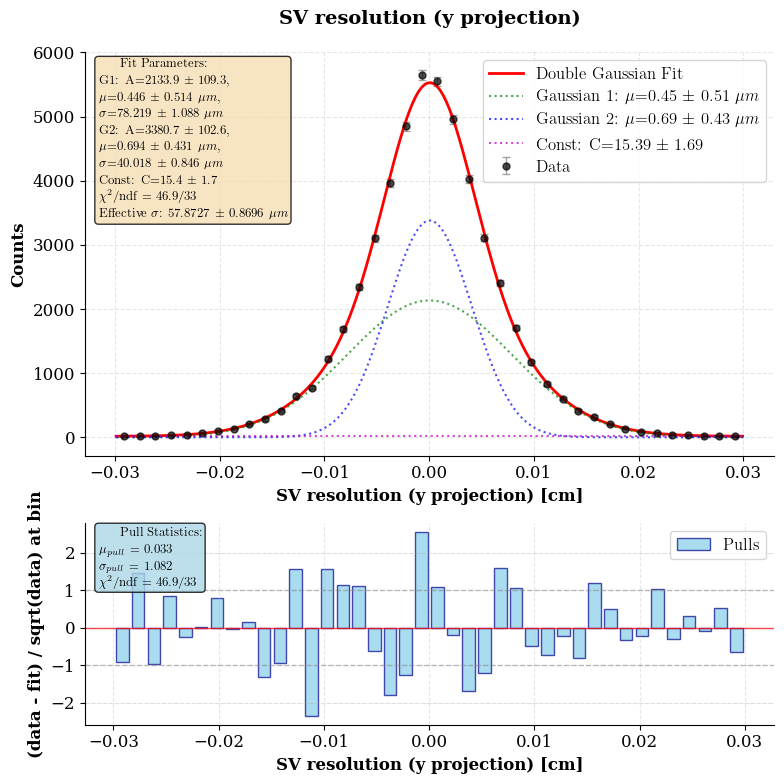

In [41]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'Lc_diff_y'

distr = proc_df.loc[proc_df['tag'] == 'Sig', distr_name]
distr_sel = distr[abs(distr) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1e4,
                unit_name='$\\mu m$'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='SV resolution (y projection)',
    x_label='SV resolution (y projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1e4,
    unit_name='$\\mu m$'
)

plt.savefig(f'../plots/{distr_name}.pdf')

# PV z-projection

## Currently missed

Method: Nelder-Mead
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
****************************************************************************************************
New best method: L-BFGS-B, success: True
****************************************************************************************************
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
****************************************************************************************************
New best method: trust-constr, success: True
****************************************************************************************************
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
*****

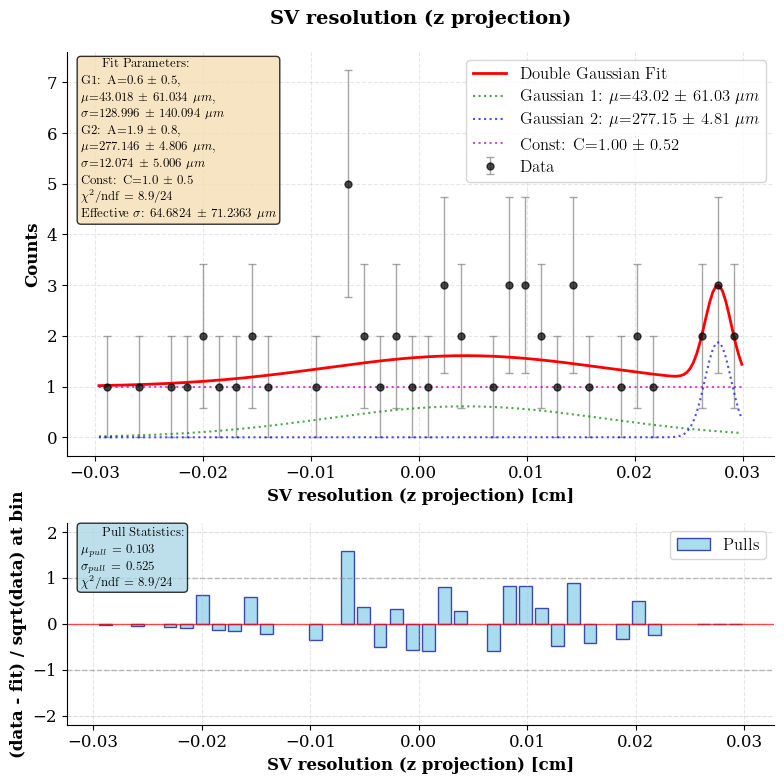

In [42]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'Lc_diff_z'

distr = proc_df.loc[proc_df['tag'] == 'Sig', distr_name]
distr_sel = distr[abs(distr) < 0.03].copy()

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1e4,
                unit_name='$\\mu m$'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='SV resolution (z projection)',
    x_label='SV resolution (z projection) [cm]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1e4,
    unit_name='$\\mu m$'
)

plt.savefig(f'../plots/{distr_name}.pdf')

# Lc fit

<Axes: >

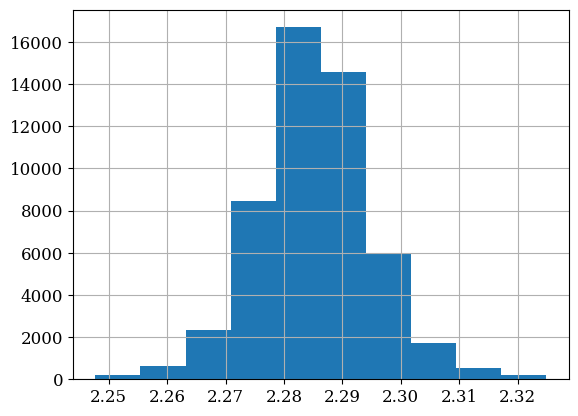

In [43]:
mass_Lc = proc_df.loc[proc_df['tag'] == 'Sig', 'mass_Lc']
mass_Lc.hist()

Method: Nelder-Mead
Method: Powell
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
Method: BFGS
Method: Newton-CG
Method: L-BFGS-B
Method: TNC
Method: COBYLA
Method: COBYQA
Method: SLSQP
Skip method: SLSQP
Method: trust-constr
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
********************************************************************************
********************************************************************************
********************************************************************************
best_method='Powell'
Optimization result:
Success: True
Message: Optimization terminated successfully.
Number of iterations: 19
Final objective value: 26.672143
Chi-squared: 26.67
Reduced chi-squared: 0.808
---------------------------------------------

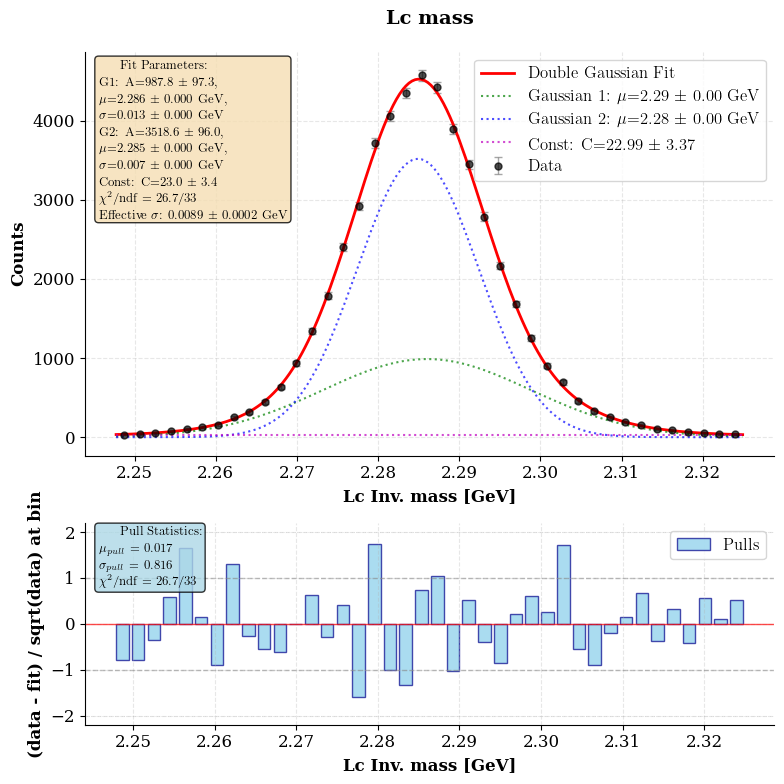

In [44]:
from analysis_scripts.fit_scripts import fit_distr_double_gauss


distr_name = 'Lc_mass'

distr = mass_Lc
distr_sel = distr

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    if method in ('SLSQP'):
        print(f'Skip method: {method}')
        continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_double_gauss(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000,
                scaler=1,
                unit_name='GeV'
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_double_gauss(
    distr=distr_sel,
    title='Lc mass',
    x_label='Lc Inv. mass [GeV]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000,
    scaler=1,
    unit_name='GeV'
)

plt.savefig(f'../plots/{distr_name}.pdf')

# Background fit

<Axes: >

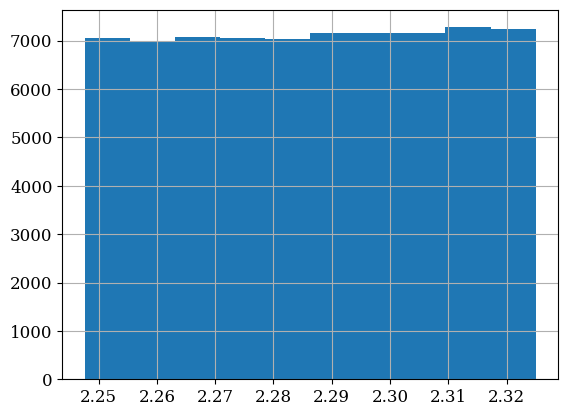

In [45]:
mass_bg = proc_df.loc[proc_df['tag'] == 'Bg', 'mass_Lc']
mass_bg.hist()

Method: Nelder-Mead
result['success']=True
****************************************************************************************************
New best method: Nelder-Mead, success: True
****************************************************************************************************
Method: Powell
result['success']=True
****************************************************************************************************
New best method: Powell, success: True
****************************************************************************************************
Method: CG
result['success']=True
Method: BFGS
result['success']=True
Method: Newton-CG
Method: L-BFGS-B
result['success']=True
Method: TNC
result['success']=True
Method: COBYLA
Method: COBYQA
result['success']=np.True_
Method: SLSQP
result['success']=True
Method: trust-constr
result['success']=True
Method: dogleg
Method: trust-ncg
Method: trust-exact
Method: trust-krylov
*********************************************************

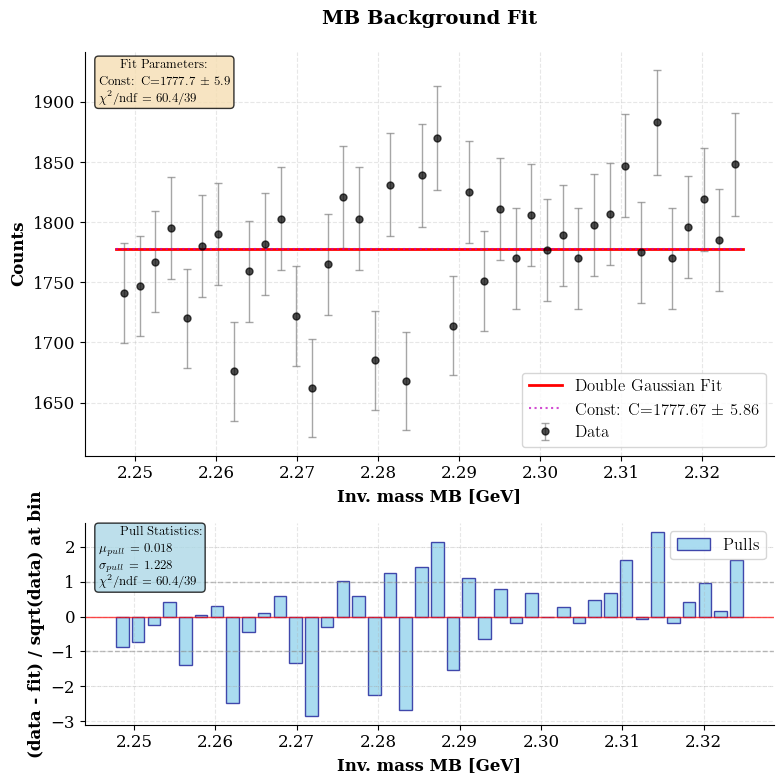

In [46]:
from analysis_scripts.fit_scripts import fit_distr_flat_bg


distr_name = 'Background'

distr = mass_bg
distr_sel = distr

methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
           'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg',
           'trust-ncg', 'trust-exact', 'trust-krylov']

min_loss = 1e6
best_method = None

for method in methods:

    print(f'Method: {method}')

    # if method in ('SLSQP'):
    #     print(f'Skip method: {method}')
    #     continue

    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        try:
            fit_res = fit_distr_flat_bg(
                distr=distr_sel,
                title=distr_name,
                x_label=distr_name + ' [cm]',
                optimize_method=method,
                plot=False,
                bins=40,
                max_iter=1000
            )
        except:
            print(f'Skip method: {method}')
            continue
    
    result = fit_res['result']
    
    print(f'{result['success']=}')
    
    if result['success'] and result['fun'] < min_loss:
        print('*'*100)
        print(f'New best method: {method}, success: {result['success']}')
        print('*'*100)
        best_method = method
        min_loss = result['fun']
    
print('*' * 80)
print('*' * 80)
print('*' * 80)
print(f'{best_method=}')

if best_method is None:
    raise ValueError('No successful fit')

result = fit_distr_flat_bg(
    distr=distr_sel,
    title='MB Background Fit',
    x_label='Inv. mass MB [GeV]',
    optimize_method=best_method,
    plot=True,
    bins=40,
    max_iter=1000
)

plt.savefig(f'../plots/{distr_name}.pdf')